In [30]:
import torch
from torch import nn
from torch.nn import functional as F

In [31]:
[5] + [5]*(10)


[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]

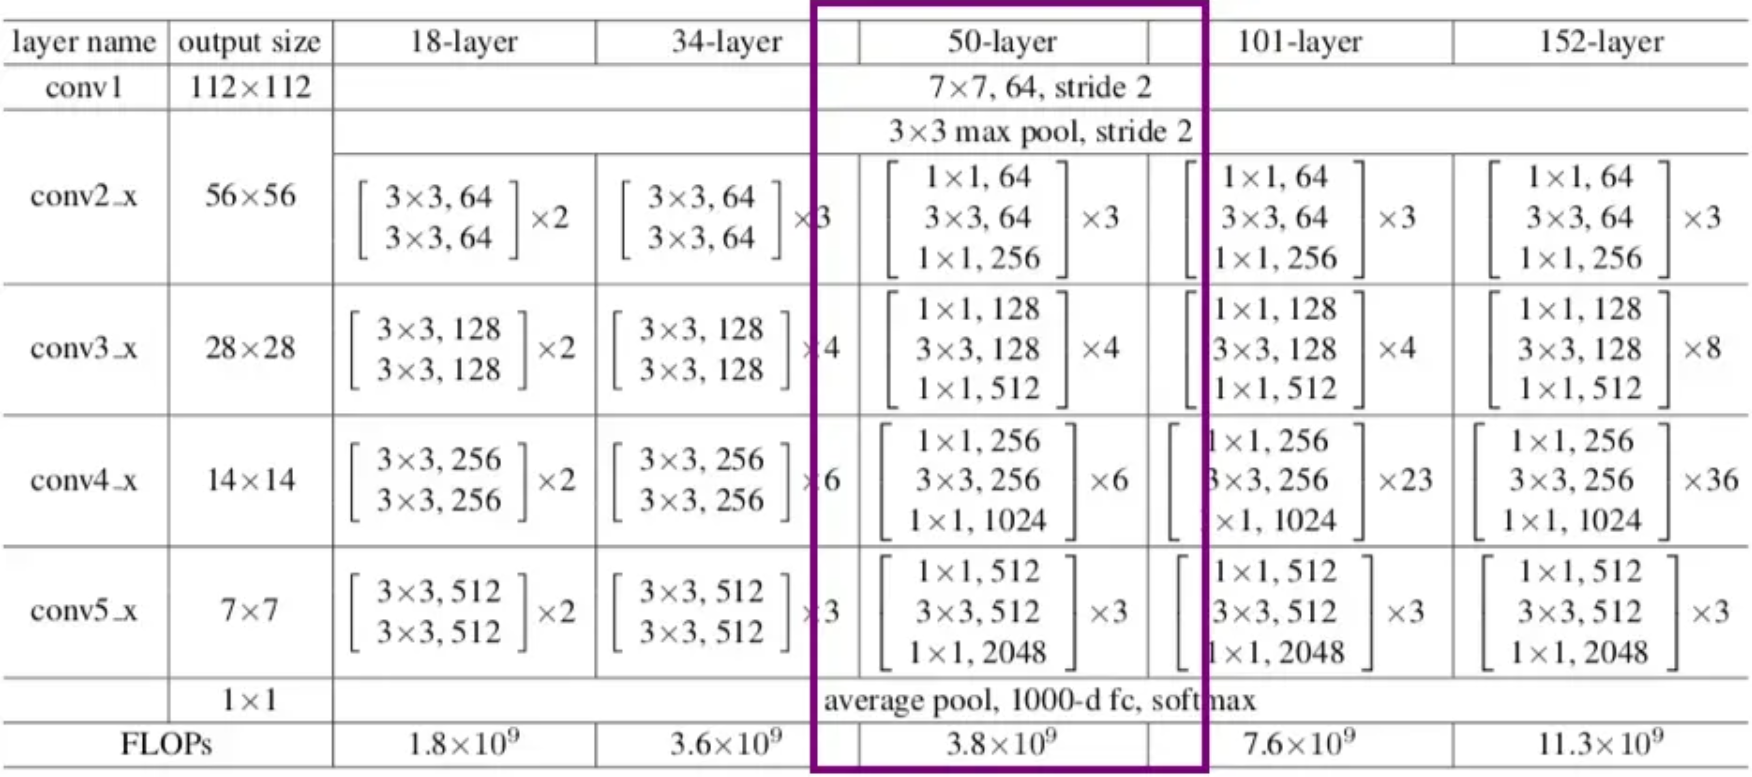

# First attempt: Replicated the structure, but not the forward function

In [32]:
def make_shortcuts(channels):
    layers = [
        nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(out_channels)
            ) if in_channels != out_channels else nn.Identity()
            for in_channels, out_channels in zip(channels[:-1], channels[1:])
    ]
    return nn.Sequential(*layers)

In [33]:
def make_block_3x3(channels, kernel_size, stride, padding, bias):
    layers = [
        nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels,
                kernel_size=kernel_size, stride=stride,
                padding=padding, bias=bias
            ),
            # nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ) for in_channels, out_channels in zip(channels[:-1], channels[1:])
    ] + [
        nn.MaxPool2d(2, 2)
    ]
    return nn.Sequential(*layers)

In [40]:
class ResNet(nn.Module):

    def __init__(
        self,
        block_out = [3, 64, 128, 256, 512],
        block_depth = [2, 2, 2, 2]
    ):
        super().__init__()

        self.shortcuts = make_shortcuts(block_out)
        
        self.blocks = [
            make_block_3x3(
                [in_channels] + [out_channels]*(depth),
                3, 1, 1, False
            )
            for in_channels, out_channels, depth in zip(
                block_out[:-1], block_out[1:], block_depth
            )
        ]
        
        # self.model = nn.Sequential(
        #     *blocks,
        #     nn.Flatten(),
        #     nn.Linear(7*7*512, 4096),
        #     nn.Linear(4096, 4096),
        #     nn.Linear(4096, 1000)
        # )
        self.model = nn.Sequential(
            *self.blocks,
            nn.AdaptiveAvgPool2d((1, 1)),  
            nn.Flatten(),
            nn.Linear(512, 1000),          
            nn.Softmax(dim=1),       
            # self.shortcuts     
        )
            
    def forward(self, x):
        out = self.model(x)
        
        return out


In [41]:
class ResNet34(ResNet):
    def __init__(self):
        super().__init__(
            block_out=[3, 64, 128, 256, 512],
            block_depth=[3, 4, 6, 3]
        )

In [42]:
def test_resnet():
    model = ResNet()
    x = torch.randn(4, 3, 224, 224)
    out = model(x)
    print(out.shape)
    print(model)

test_resnet()

torch.Size([4, 1000])
ResNet(
  (shortcuts): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (model): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1)

# Second attempt

In [43]:
class Residual(nn.Module):
    expansion = 1  
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            # Adjust the dimensions via a 1x1 convolution
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out += identity
        out = F.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # lảer1 
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # layer2
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # layer3
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.relu = nn.ReLU(inplace=True)


        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        identity = self.shortcut(x)

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        out += identity
        out = self.relu(out)

        return out
 


In [44]:

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        super().__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(3, stride=2, padding=1)

        # Residual layers
        self.layer1 = self._make_layer(block, 64, layers[0])  
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)  
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)  
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)  

        # Final layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride=1):
        layers = []

        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion

        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        res = self.relu(self.bn1(self.conv1(x)))
        res = self.pool1(res)

        res = self.layer1(res)
        res = self.layer2(res)
        res = self.layer3(res)
        res = self.layer4(res)

        res = self.avgpool(res)
        res = torch.flatten(res, 1)  
        res = self.fc(res)

        return res  
   

In [45]:
    
def create_resnet(model_depth, num_classes=1000):
    if model_depth == 18:
        return ResNet(Residual, [2, 2, 2, 2], num_classes)
    elif model_depth == 34:
        return ResNet(Residual, [3, 4, 6, 3], num_classes)
    elif model_depth == 50:
        return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)
    elif model_depth == 101:
        return ResNet(Bottleneck, [3, 4, 23, 3], num_classes)
    elif model_depth == 152:
        return ResNet(Bottleneck, [3, 8, 36, 3], num_classes)

In [46]:

def test_resnet():
    depths = [18, 34, 50, 101, 152]

    for depth in depths:
        print(f"model {depth}")
        model = create_resnet(depth, num_classes=1000)
        x = torch.randn(4, 3, 224, 224) 
        res = model(x)
        print(model)
        print(f"shape {res.shape}")

test_resnet()

model 18
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kern